# Sparkify Project Workspace AWS - Full Dataset (12GB)

## Overview

**Sparkify is a popular (not real!) music service** similar to Spotify or Pandora with a **subscription-based business model**. Each user can listen to their favorite music every day either through the **free-tier** that inserts advertisements between songs or by using a **subscription plan where she pays a fixed monthly fee**. Users can **upgrade, downgrade, or cancel the service at any time**, so it's critical to be sure users love the service. 

**Every time a user interacts with the service it generates (synthetic) data**. Each event (e.g., song played, logout, like, downgrade, ...) is recorded with the corresponding timestamp. All of this information holds the key to keeping users happy and businesses thriving.

The **goal** of the problem is to help Sparkify in answering the following question:<br>

**Which users are at risk of churn, i.e. downgrade from premium service to free-tier plan or cancellation of service altogether?**

By **identifying** these **users before they abandon the service**, Sparkify can **proactively engage with them** by offering some discounts and/or incentives, which can **save a lot of time and money in acquiring new users**.

In this notebook, you can find some **data analysis and model building with Spark (Pyspark and SparkML libraries) run on the full dataset available (12GB)**.

## Cluster Configuration

In this workspace, we configure the cluster with the following settings: <br>
- Realease label: `emr 6.1.1`
- Application: `Spark 3.0.0, Zeppelin 0.9.0`
- Instance type: `m5a.2xlarge`
- Number of instances: `6`
- EC2 key pair: `Proceed without an EC2 key pair`

In [1]:
print("Welcome to my EMR Notebook!")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1635985451616_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Welcome to my EMR Notebook!

## Installing Missing Libraries 

In [2]:
# sc.install_pypi_package("Cython")
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("matplotlib==3.2.2", "https://pypi.org/simple")
sc.install_pypi_package("seaborn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…




You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [3]:
# Check the list of packages installed
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

aws-cfn-bootstrap (2.0)
beautifulsoup4 (4.9.1)
boto (2.49.0)
click (7.1.2)
cycler (0.11.0)
docutils (0.14)
jmespath (0.10.0)
joblib (0.15.1)
kiwisolver (1.3.2)
lockfile (0.11.0)
lxml (4.5.1)
matplotlib (3.2.2)
mysqlclient (1.4.2)
nltk (3.5)
nose (1.3.4)
numpy (1.16.5)
pandas (1.0.5)
pip (9.0.1)
py-dateutil (2.2)
pyparsing (3.0.4)
pystache (0.5.4)
python-daemon (2.2.3)
python-dateutil (2.8.2)
python37-sagemaker-pyspark (1.3.0)
pytz (2020.1)
PyYAML (5.3.1)
regex (2020.6.8)
scipy (1.7.1)
seaborn (0.11.2)
setuptools (28.8.0)
simplejson (3.2.0)
six (1.13.0)
soupsieve (1.9.5)
tqdm (4.46.1)
wheel (0.29.0)
windmill (1.6)

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DateType
from pyspark.sql import Window
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, IndexToString
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.sql.types import *

import seaborn as sns


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Create a Spark session

In [5]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Import data from S3 Repository

In [6]:
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Explore and Prepare Data

In [7]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [8]:
# check dataframe shape
print(f'The dataset at hand contains {df.count()} events and {len(df.columns)} features recorded.')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The dataset at hand contains 26259199 events and 18 features recorded.

In [9]:
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [26]:
num_unique_users = df.select(F.countDistinct('userId'))
num_unique_users= num_unique_users.head()[0]
print(f'There are {num_unique_users} unique users.')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 22278 unique users.

In [27]:
# check for missing values

def count_missing(df, col):
    """
    Function that counts missing values (nan, null, empty) in a column of the dataset.
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print(f"{col}: {missing_count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

artist: 5408927
firstName: 778479
gender: 778479
lastName: 778479
length: 5408927
location: 778479
registration: 778479
song: 5408930
userAgent: 778479

From the above count, we observe that:
1. There is **missing information for users not logged in**.
2. There are a lot of **missing values in *song*, *lenght*, *artist* columns** which may correspond to the events where the user is not listening to music.

In [7]:
def clean_data(df):
    '''
    Function that performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'firstName' column and duplicates if any
    '''
    
    # remove rows where firstName is empty and duplicated rows
    df_clean = df.filter(df["firstName"].isNotNull()).dropDuplicates()

    return df_clean


def get_date_from_timestamp(df, col_name, new_col_name):
    '''
    Function that convert timestamp to date
    '''
    
    return df.withColumn(new_col_name, F.to_timestamp(F.col(col_name) / 1000).astype(StringType()))


def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning models.
    
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning which
    contains the following columns:
    
    1. userId - initial id of the user
    2. gender - user's gender
    3. days_registered - days since user's registration
    4. last_state - current state of the user
    5. avg_songs_per_day - average songs played per day
    6. last_level - current subscription plan
    7. Thumbsup_proportion - ratio of thumbs up over thumbs down
    8. num_add_friends - number of add friends events
    9. avg_roll_adv_per_day - average number of roll adv played per day
    10. churn_cancellation
    '''
    
    # Clean dataset using clean_data function
    df = clean_data(df)
    
    # Convert event timestamp
    df = get_date_from_timestamp(df, 'ts', 'ts_date')
    
    # Convert registration timestamp
    df = get_date_from_timestamp(df, 'registration', 'registration_date')
    
    # Create column Churn when the event recorded is 'Cancellation Confirmation'. 
    # A value equal to 1 indicates that the user cancelled the subscription.
    churn_cancellation = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
    
    df = df.withColumn("churn_cancellation", churn_cancellation("page"))
    
    # Get userId with churn_cancellation == 1
    cancelled_users = df.select(['userId']).where(df.churn_cancellation == 1).groupby('userId').count().toPandas()['userId'].values
    cancelled_users = list(cancelled_users)
    df = df.withColumn('churn_cancellation', when((df.userId).isin(cancelled_users), 1).otherwise(0))
    
    # Convert column gender to numeric: 1 for 'female' and 0 for 'male'
    gender = udf(lambda x: 1 if x=="F" else 0, IntegerType())
    
    df = df.withColumn("gender", gender("gender"))
    
    # Convert column level to numeric: 1 for 'paid' and 0 for 'free'
    level = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    
    #df = df.withColumn("level", level("level"))
    
    levels = df.select(['userId', 'level', 'ts_date'])\
                        .orderBy(desc('ts_date'))\
                        .dropDuplicates(['userId'])\
                        .select(['userId', 'level'])\
                        .withColumn('last_level', level('level').cast(IntegerType()))
    levels = levels.drop('level')
    levels = levels.withColumnRenamed('userId', 'level_userId')

    
    # Compute active days as number of days since registration
    # Create dataframe with last timestamp (ts_date) per user
    df_last_ts = df.groupBy('userId').agg(max('ts_date').alias('last_interaction'))
    
    # Join dataframes and add column 'days_registered' with number of days from registration date to ts for last event
    df = df.join(df_last_ts, on='userId').select(df_last_ts['*'], df['*']).withColumn('days_registered', datediff(df_last_ts['last_interaction'], df['registration_date']).cast('float'))
    
    # Create a new column 'date' with format 'yyyy-MM-dd'
    df = df.withColumn('date', date_format('ts_date', 'yyyy-MM-dd').alias('date'))
    
    # Create a new column 'last_state' where the last session was recorded
    df = df.withColumn("state", substring(df.location, -2, 2))
    df = df.withColumn('last_state', when(df_last_ts.last_interaction == df.ts_date, df.state))
        
    # Compute average songs played by day per user
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs_per_day', avg('songs').over(w))
    songs = songs.select(songs['userId'].alias('songs_userId'), 'avg_songs_per_day')
    songs = songs.withColumn('avg_songs_per_day', F.round(songs['avg_songs_per_day'],2)).distinct()
    
    # Compute the number of thumbs up for user
    w = Window.partitionBy('userId')
    thumbs_up = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbs_up = thumbs_up.select(thumbs_up['userId'].alias('thumbsup_userId'), 'thumbs_up')
 
    # Compute the number of thumbs down per user
    w = Window.partitionBy('userId')
    thumbs_down = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbs_down = thumbs_down.select(thumbs_down['userId'].alias('thumbsdown_userId'), 'thumbs_down')
      
    # Compute the number of add friend events per user
    w = Window.partitionBy('userId')
    num_add_friend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('num_add_friend')).distinct()
    num_add_friend = num_add_friend.select(num_add_friend['userId'].alias('friends_userId'), 'num_add_friend')
    
    # Compute the fraction of page 'roll advert'
    w = Window.partitionBy('userId', 'date')
    roll_adv = df.where(df.page == 'Roll Advert').select('userId', 'date', count('userId').over(w).alias('roll_adv')).distinct()
    w = Window.partitionBy('userId')
    roll_adv = roll_adv.withColumn('avg_roll_adv_per_day', avg('roll_adv').over(w))
    roll_adv = roll_adv.select(roll_adv['userId'].alias('rolladv_userId'), 'avg_roll_adv_per_day')
    roll_adv = roll_adv.withColumn('avg_roll_adv_per_day', F.round(roll_adv['avg_roll_adv_per_day'],2)).distinct()
    
    # Construct the final dataset
    df_ml = df.select('userId', 'gender', 'churn_cancellation', 'days_registered', 'last_state').dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId, how='left').distinct() 
    df_ml = df_ml.join(levels, df_ml.userId == levels.level_userId, how='left').distinct()
    df_ml = df_ml.join(thumbs_up, df_ml.userId == thumbs_up.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbs_down, df_ml.userId == thumbs_down.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.withColumn('Thumbsup_proportion', F.round(df_ml.thumbs_up / df_ml.thumbs_down, 2))
    df_ml = df_ml.fillna(0, subset=['Thumbsup_proportion'])
    df_ml = df_ml.join(num_add_friend, df_ml.userId == num_add_friend.friends_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['num_add_friend'])
    df_ml = df_ml.join(roll_adv, df_ml.userId == roll_adv.rolladv_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['avg_roll_adv_per_day'])
    df_ml = df_ml.drop('thumbs_up', 'thumbs_down', 'songs_userId', 'level_userID', 'rolladv_userId', 'thumbsup_userId', 'thumbsdown_userId', 'friends_userId')

    return df_ml


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
df_ml = prepare_dataset(df)    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
df_ml_pandas = df_ml.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
df_ml_pandas.shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22277

In [47]:
df_ml_pandas.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    userId  gender  ...  num_add_friend  avg_roll_adv_per_day
0  1001393       0  ...              11                  0.00
1  1004060       0  ...              54                  1.75
2  1004316       0  ...              18                  2.00
3  1006033       1  ...              19                  1.00
4  1008404       1  ...              88                  4.50

[5 rows x 10 columns]

In [48]:
df_ml_pandas.churn_cancellation.value_counts()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0    17274
1     5003
Name: churn_cancellation, dtype: int64

In [50]:
# Check correlation with the target variable 'churn_cancellation'
df_ml_pandas.corr()['churn_cancellation'].abs().sort_values(ascending = False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

churn_cancellation      1.000000
days_registered         0.258629
avg_roll_adv_per_day    0.168737
Thumbsup_proportion     0.109772
avg_songs_per_day       0.108886
last_level              0.032728
num_add_friend          0.029913
gender                  0.008486
Name: churn_cancellation, dtype: float64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

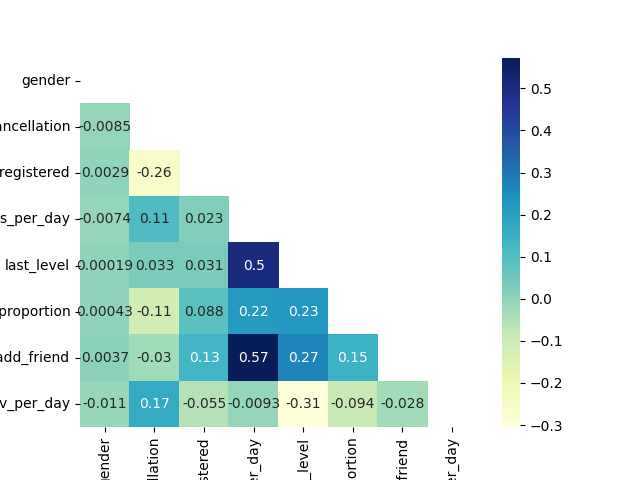

In [52]:
# Check correlation among features

# creating mask
mask = np.triu(np.ones_like(df_ml_pandas.corr()))
 
# plotting a triangle correlation heatmap
plt.clf()

dataplot = sns.heatmap(df_ml_pandas.corr(), cmap="YlGnBu", annot=True, mask=mask)

# displaying heatmap
plt.show()

%matplot plt

## Modeling

In this section, we follow the following steps: <br>
- Split the full dataset into train and test sets. 
- Test out several of the machine learning methods (Logistic Regression, Random Forest, Gradient-Boosting Tree). 
- Evaluate the accuracy of the various models, tuning parameters as necessary. 
- Determine the winning model based on test F1-score.

**Note on metrics:**<br>
Typically, when we look at the results of a classification model, we focus on the correct predictions of all the predictions made by the model, i.e., the accuracy of the model.<br>
In our case, when doing a **churn analysis with the goal of predicting customers who churned**, we are particularly interested in **having a lot of true positives**. However, since there are many customers who have not churned (**highly unbalanced datasets**), **the higher the number of true negatives the higher the accuracy**, which can be misleading. Thus, a **better measure of model performance in this case is the F1 score**, which is the harmonic mean of Precision ('out of all customers who were labeled as "churned," how many did we correctly label as such?') and Recall ('out of all customers who were labeled as "churned," how many actually churned?').

In [9]:
# Model Evaluator User Defined Functions
def udfModelEvaluator(dfPredictions, labelColumn='label'):

    colSelect = dfPredictions.select(
      [F.col('prediction').cast(DoubleType())
       ,F.col(labelColumn).cast(DoubleType()).alias('label')])

    metrics = MulticlassMetrics(colSelect.rdd)

    mMatrix = metrics.confusionMatrix().toArray().astype(int)    

    mTP = metrics.confusionMatrix().toArray()[1][1]
    mTN = metrics.confusionMatrix().toArray()[0][0]
    mFP = metrics.confusionMatrix().toArray()[0][1]
    mFN = metrics.confusionMatrix().toArray()[1][0]
    
    mAccuracy = metrics.accuracy
    mPrecision = mTP / (mTP + mFP)
    mRecall = mTP / (mTP + mFN)
    mF1 = metrics.fMeasure(1.0)

    mResults = [mAccuracy, mPrecision, mRecall, mF1, mMatrix, mTP, mTN, mFP, mFN, "Return [[0]=Accuracy, [1]=Precision, [2]=Recall, [3]=F1, [4]=ConfusionMatrix, [5]=TP, [6]=TN, [7]=FP, [8]=FN]"]

    return mResults

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Split into Train and Test sets

In [10]:
# split into train and test sets (80% - 20%)

df_ml = df_ml.withColumnRenamed("churn_cancellation", "label")

train, test = df_ml.randomSplit([0.8, 0.2], seed = 42)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Count users by label in train set
counts_train = train.groupBy('label').count().toPandas()
#print(counts_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# Counts
count_churned = counts_train[counts_train['label']==1]['count'].values[0]
count_total = counts_train['count'].sum()

# Weights
c = 2
weight_churned = count_total / (c * count_churned)
weight_no_churned = count_total / (c * (count_total - count_churned))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Create a new column 'weight' containing a weight for each observation according to its class (i.e. churned / not churned)
train = train.withColumn("weight", when(train.label ==1, weight_churned).otherwise(weight_no_churned))
train.select('label', 'weight').where(train.label ==1).show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------------+
|label|           weight|
+-----+-----------------+
|    1|2.231976890228586|
|    1|2.231976890228586|
|    1|2.231976890228586|
+-----+-----------------+
only showing top 3 rows

### Machine Learning Pipelines

In [14]:
# Index and encode categorical feature 'last_state'
stringIndexerState = StringIndexer(inputCol="last_state", 
                                   outputCol="stateIndex")

encoder = OneHotEncoder(inputCol="stateIndex",
                        outputCol="stateVec")

# Create a vector for features to be used in the models
features = ['stateVec', 'gender', 'days_registered', 'avg_songs_per_day', 'last_level', 'Thumbsup_proportion', 'num_add_friend', 'avg_roll_adv_per_day']

# Merge multiple columns into a vector column
assemblers = VectorAssembler(inputCols=features, outputCol="rawFeatures", handleInvalid = "keep")

# Scale features
scalers = MinMaxScaler(inputCol="rawFeatures", outputCol='features')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Logistic Regression Classifier

In [63]:
# Initialize Logistic Regression Classifier
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Assemble pipeline
pipeline_lr = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, lr])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Cross Validation and Parameter Tuning

In [64]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 30, 50]) \
    .addGrid(lr.regParam, [0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.8])\
    .addGrid(lr.family, ['auto'])\
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
#cvModel_lr = crossval_lr.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# Save model results
#cvModel_lr.save("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_lr.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
# Upload model results
cvModel_lr_loaded = CrossValidatorModel.load("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_lr.mdl/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
bestModel_lr = cvModel_lr_loaded.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
pred_train_best_lr = bestModel_lr.transform(train)
pred_test_best_lr = bestModel_lr.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
predictionAndLabels = pred_train_best_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_lr = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_lr[0]}')
print(f'Precision: {metricsList_train_best_lr[1]}')
print(f'Recall: {metricsList_train_best_lr[2]}')
print(f'F1-score: {metricsList_train_best_lr[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Train set:
 
Accuracy: 0.7759833436497665
Precision: nan
Recall: 0.0
F1-score: 0.0
 
<string>:18: RuntimeWarning: invalid value encountered in double_scalars

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

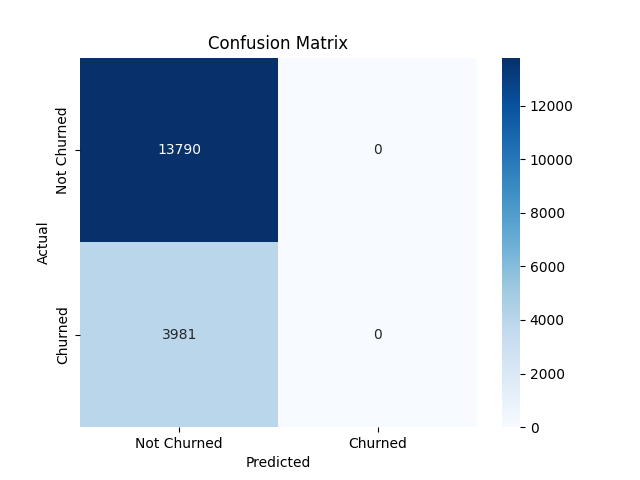

In [19]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_train_best_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [20]:
predictionAndLabels = pred_test_best_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_lr = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_lr[0]}')
print(f'Precision: {metricsList_test_best_lr[1]}')
print(f'Recall: {metricsList_test_best_lr[2]}')
print(f'F1-score: {metricsList_test_best_lr[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Test set:
 
Accuracy: 0.7731913004882379
Precision: nan
Recall: 0.0
F1-score: 0.0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

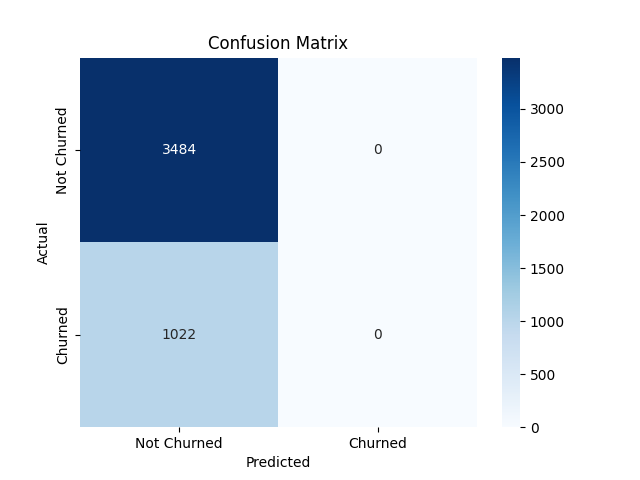

In [21]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_test_best_lr[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [75]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_lr.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_lr = pd.DataFrame.from_dict([
    {cvModel_lr.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_lr.avgMetrics)
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [76]:
validation_results_lr

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         f1  maxIter  regParam  elasticNetParam family
0  0.677663       10       0.1              0.8   auto
1  0.677663       10       0.3              0.8   auto
2  0.677663       30       0.1              0.8   auto
3  0.677663       30       0.3              0.8   auto
4  0.677663       50       0.1              0.8   auto
5  0.677663       50       0.3              0.8   auto

### Logistic Regression Classifier with Weights

In [77]:
# Initialize Logistic Regression Classifier
lr_weighted = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial", weightCol="weight")

# Assemble pipeline
pipeline_lr_weighted = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, lr_weighted])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Cross Validation and Parameter Tuning

In [78]:
paramGrid_lr_weighted = ParamGridBuilder() \
    .addGrid(lr_weighted.maxIter, [10, 30, 50]) \
    .addGrid(lr_weighted.regParam, [0.1, 0.3]) \
    .addGrid(lr_weighted.elasticNetParam, [0.8])\
    .addGrid(lr_weighted.family, ['auto'])\
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
crossval_lr_weighted = CrossValidator(estimator=pipeline_lr_weighted,
                          estimatorParamMaps=paramGrid_lr_weighted,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
#cvModel_lr_weighted = crossval_lr_weighted.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
# Save model results

#cvModel_lr_weighted.save("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_lr_weighted.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
# Upload model results

cvModel_lr_weighted_loaded = CrossValidatorModel.load("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_lr_weighted.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
bestModel_lr_weighted = cvModel_lr_weighted_loaded.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
pred_train_best_lr_w = bestModel_lr_weighted.transform(train)
pred_test_best_lr_w = bestModel_lr_weighted.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
predictionAndLabels = pred_train_best_lr_w.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_lr_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_lr_w[0]}')
print(f'Precision: {metricsList_train_best_lr_w[1]}')
print(f'Recall: {metricsList_train_best_lr_w[2]}')
print(f'F1-score: {metricsList_train_best_lr_w[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

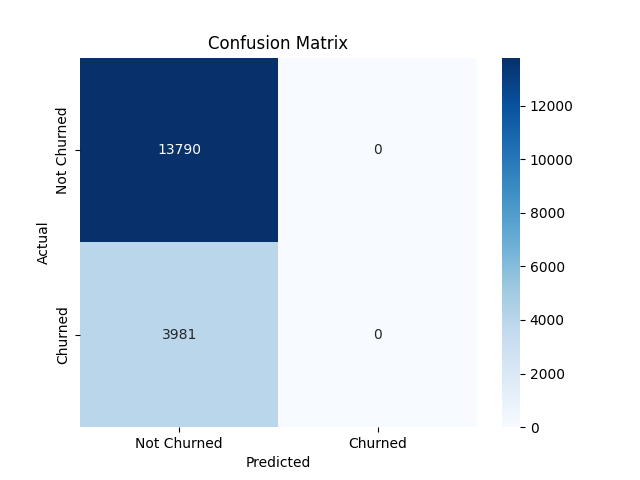

In [26]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_train_best_lr_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [27]:
predictionAndLabels = pred_test_best_lr_w.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_lr_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_lr_w[0]}')
print(f'Precision: {metricsList_test_best_lr_w[1]}')
print(f'Recall: {metricsList_test_best_lr_w[2]}')
print(f'F1-score: {metricsList_test_best_lr_w[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Test set:
 
Accuracy: 0.7731913004882379
Precision: nan
Recall: 0.0
F1-score: 0.0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

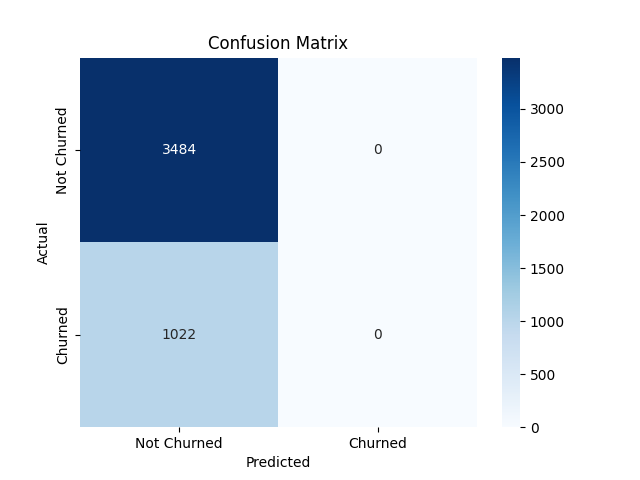

In [28]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_test_best_lr_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

### Random Forest Classifier

In [97]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Assemble pipeline
pipeline_rf = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, rf])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Cross Validation and Parameters Tuning

In [98]:
# Create ParamGrid for Cross Validation
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [3, 4, 5]) \
    .addGrid(rf.impurity, ['entropy', 'gini'])\
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [99]:
crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [100]:
#cvModel_rf = crossval_rf.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
# Save model results

#cvModel_rf.save("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_rf.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# Upload model results

cvModel_rf_loaded = CrossValidatorModel.load("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_rf.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
bestModel_rf = cvModel_rf_loaded.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
pred_train_best_rf = bestModel_rf.transform(train)
pred_test_best_rf = bestModel_rf.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
predictionAndLabels = pred_train_best_rf.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_rf = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_rf[0]}')
print(f'Precision: {metricsList_train_best_rf[1]}')
print(f'Recall: {metricsList_train_best_rf[2]}')
print(f'F1-score: {metricsList_train_best_rf[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Train set:
 
Accuracy: 0.7947780091159755
Precision: 0.8211538461538461
Recall: 0.10725948254207486
F1-score: 0.18973561430793157

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

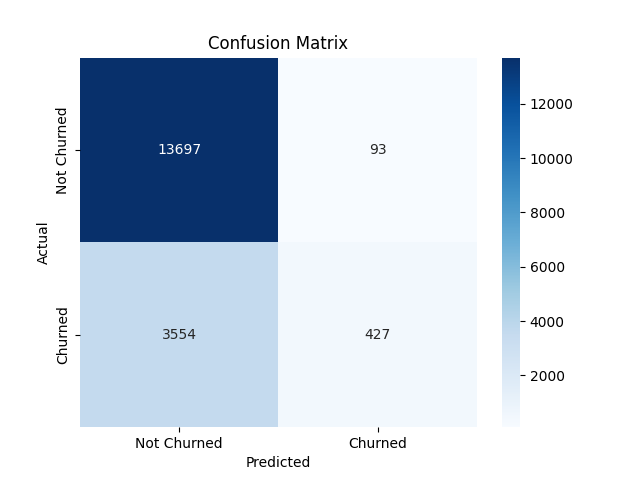

In [50]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_train_best_rf[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [51]:
predictionAndLabels = pred_test_best_rf.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_rf = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_rf[0]}')
print(f'Precision: {metricsList_test_best_rf[1]}')
print(f'Recall: {metricsList_test_best_rf[2]}')
print(f'F1-score: {metricsList_test_best_rf[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Test set:
 
Accuracy: 0.7902796271637816
Precision: 0.8130081300813008
Recall: 0.09784735812133072
F1-score: 0.17467248908296942

Exception in thread cell_monitor-51:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 35248



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

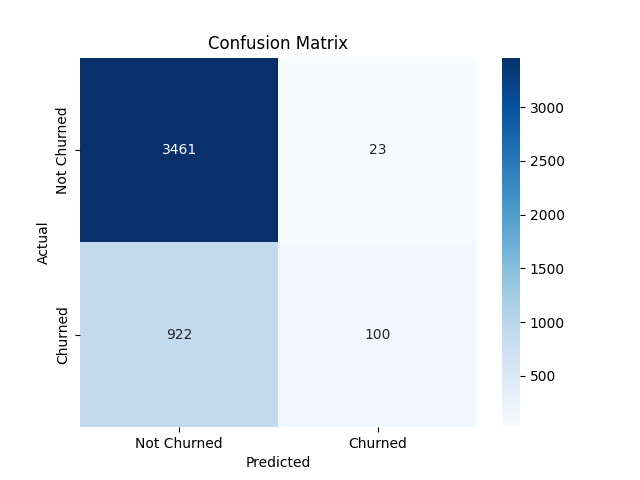

In [52]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_test_best_rf[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [110]:
# Check the parameters of the best model
bestModel = bestModel_rf.stages[4]
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('impurity - ', bestModel.getOrDefault('impurity'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

numTrees -  20
maxDepth -  5
impurity -  gini

In [111]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_rf.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_rf = pd.DataFrame.from_dict([
    {cvModel_rf.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_rf.avgMetrics)
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [112]:
validation_results_rf

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          f1  numTrees  maxDepth impurity
0   0.684356        10         3  entropy
1   0.685286        10         3     gini
2   0.702369        10         4  entropy
3   0.714410        10         4     gini
4   0.711059        10         5  entropy
5   0.728561        10         5     gini
6   0.678672        20         3  entropy
7   0.687018        20         3     gini
8   0.708819        20         4  entropy
9   0.717062        20         4     gini
10  0.723865        20         5  entropy
11  0.737886        20         5     gini
12  0.677663        30         3  entropy
13  0.677663        30         3     gini
14  0.686979        30         4  entropy
15  0.687863        30         4     gini
16  0.709968        30         5  entropy
17  0.720845        30         5     gini

### Random Forest Classifier with weights

In [15]:
# Initialize Random Forest Classifier
rf_weighted = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, weightCol="weight")

# Assemble pipeline
pipeline_rf_weighted = Pipeline(stages=[stringIndexerState, encoder, assemblers, scalers, rf_weighted])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Cross Validation and Parameters Tuning

In [16]:
# Create ParamGrid for Cross Validation
paramGrid_rf_weighted = ParamGridBuilder() \
    .addGrid(rf_weighted.numTrees, [10, 20, 30, 50, 100]) \
    .addGrid(rf_weighted.maxDepth, [3, 4, 5]) \
    .addGrid(rf_weighted.impurity, ['entropy', 'gini'])\
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
crossval_rf_weighted = CrossValidator(estimator=pipeline_rf_weighted,
                          estimatorParamMaps=paramGrid_rf_weighted,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
#cvModel_rf_weighted = crossval_rf_weighted.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-18:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 8045



In [19]:
# Save model results

#cvModel_rf_weighted.save('s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_rf_weighted.mdl')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# Upload model results

cvModel_rf_weighted_loaded = CrossValidatorModel.load('s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_rf_weighted.mdl')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
bestModel_rf_weighted = cvModel_rf_weighted_loaded.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
pred_train_best_rf_weighted = bestModel_rf_weighted.transform(train)
pred_test_best_rf_weighted = bestModel_rf_weighted.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
predictionAndLabels = pred_train_best_rf_weighted.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_rf_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_rf_w[0]}')
print(f'Precision: {metricsList_train_best_rf_w[1]}')
print(f'Recall: {metricsList_train_best_rf_w[2]}')
print(f'F1-score: {metricsList_train_best_rf_w[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Train set:
 
Accuracy: 0.7892071352203027
Precision: 0.5261634379870853
Recall: 0.5935694549108265
F1-score: 0.5578375826251181

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

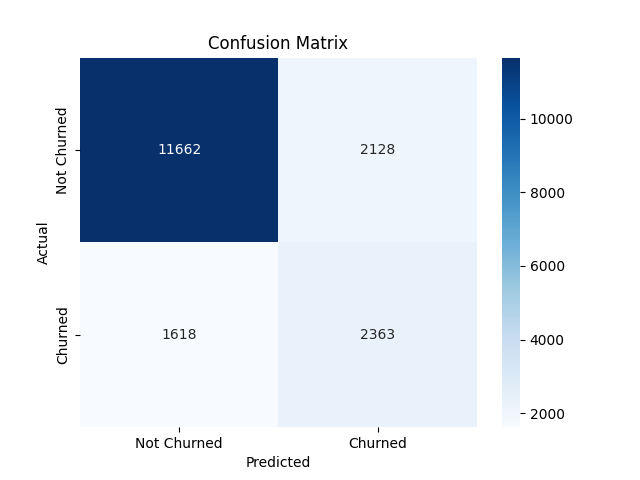

In [24]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_train_best_rf_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [25]:
predictionAndLabels = pred_test_best_rf_weighted.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_rf_w = udfModelEvaluator(predictionAndLabels, "label")

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_rf_w[0]}')
print(f'Precision: {metricsList_test_best_rf_w[1]}')
print(f'Recall: {metricsList_test_best_rf_w[2]}')
print(f'F1-score: {metricsList_test_best_rf_w[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-25:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 34482



Metrics Test set:
 
Accuracy: 0.7885042166000887
Precision: 0.5299739357080799
Recall: 0.5968688845401174
F1-score: 0.5614358030372757

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

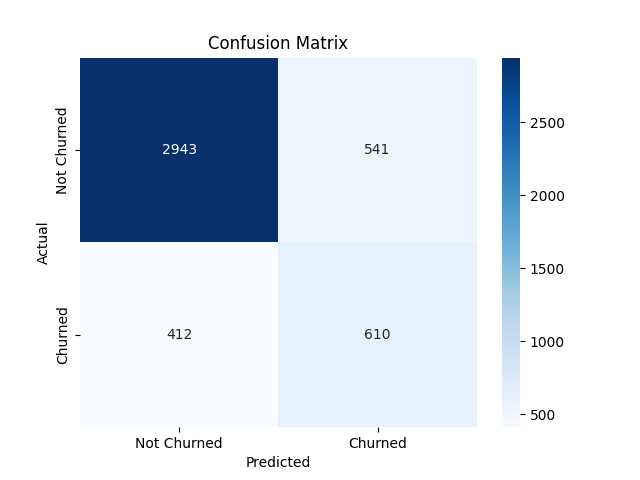

In [26]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_test_best_rf_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

### Gradient-Boosted Tree Classifier

In [15]:
# Initialize Gradient-Boosting Tree Classifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Assemble pipeline
pipeline_gbt = Pipeline(stages = [stringIndexerState, encoder, assemblers, scalers, gbt])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Cross Validation and Parameter Tuning

In [16]:
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .addGrid(gbt.maxDepth, [2, 3, 5]) \
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
#cvModel_gbt = crossval_gbt.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-18:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6367



In [53]:
# cvModel_gbt.save("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_gbt.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
cvModel_gbt_loaded = CrossValidatorModel.load("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_gbt.mdl/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
bestModel_gbt = cvModel_gbt_loaded.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
pred_train_best_gbt = bestModel_gbt.transform(train)
pred_test_best_gbt = bestModel_gbt.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
predictionAndLabels = pred_train_best_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_gbt = udfModelEvaluator(predictionAndLabels, "label")
metricsList_train_best_gbt

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_gbt[0]}')
print(f'Precision: {metricsList_train_best_gbt[1]}')
print(f'Recall: {metricsList_train_best_gbt[2]}')
print(f'F1-score: {metricsList_train_best_gbt[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Train set:
 
Accuracy: 0.8446907883630634
Precision: 0.7577036724356269
Recall: 0.45089173574478775
F1-score: 0.5653543307086615

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

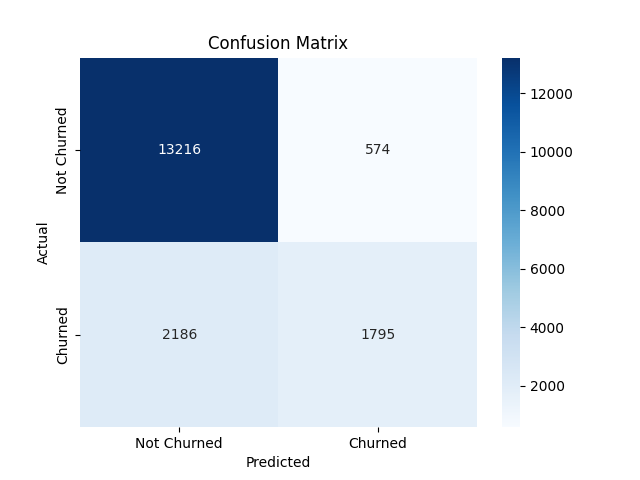

In [31]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_train_best_gbt[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [32]:
predictionAndLabels = pred_test_best_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_gbt = udfModelEvaluator(predictionAndLabels, "label")
metricsList_test_best_gbt

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_gbt[0]}')
print(f'Precision: {metricsList_test_best_gbt[1]}')
print(f'Recall: {metricsList_test_best_gbt[2]}')
print(f'F1-score: {metricsList_test_best_gbt[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-30:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 34694



Metrics Test set:
 
Accuracy: 0.841988459831336
Precision: 0.7618243243243243
Recall: 0.44129158512720157
F1-score: 0.5588599752168525

Exception in thread cell_monitor-32:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 34791



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

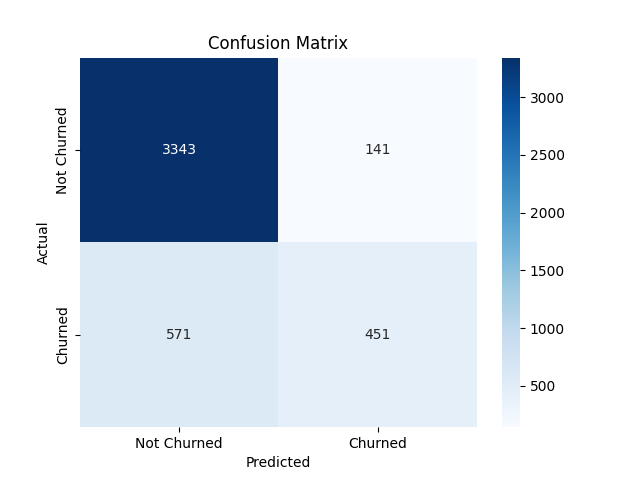

In [33]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_test_best_gbt[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [25]:
bestModel = bestModel_gbt.stages[4]
importances = bestModel.featureImportances.toArray()
x_values = list(range(len(importances)))

# Retrieve features'| labels
features_sel = ['gender', 'days_registered', 'avg_songs_per_day', 'last_level', 'Thumbsup_proportion', 'num_add_friend', 'avg_roll_adv_per_day']
features_states = bestModel_gbt.stages[0].labels
features_labels = features_states + features_sel
feature_coef_df = pd.DataFrame(list(zip(features_labels, importances)), columns=['Feature', 'Importance'])\
    .sort_values('Importance', ascending=False)

# Plot the feature importance of the best model
plt.figure(figsize=(10, 8), dpi=80)

sns.barplot(x='Importance', y='Feature', data=feature_coef_df, orient = 'h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Feature Importance')

In [26]:
# Get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel_gbt.getEstimatorParamMaps()]

# Convert validation results to pandas dataframe
validation_results_gbt = pd.DataFrame.from_dict([
    {cvModel_gbt.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel_gbt.avgMetrics)
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
validation_results_gbt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         f1  maxIter  maxDepth
0  0.803266       10         2
1  0.804125       10         3
2  0.810148       10         5
3  0.806404       20         2
4  0.808691       20         3
5  0.811155       20         5
6  0.810718       40         2
7  0.811054       40         3
8  0.813039       40         5

### Gradient-Boosted Tree Classifier with weights

In [31]:
# Initialize Gradient-Boosting Tree Classifier
gbt_weighted = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, weightCol="weight")

# Assemble pipeline
pipeline_gbt_weighted = Pipeline(stages = [stringIndexerState, encoder, assemblers, scalers, gbt_weighted])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Cross Validation and Parameter Tuning

In [32]:
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .addGrid(gbt.maxDepth, [2, 3, 5]) \
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
crossval_gbt_weighted = CrossValidator(estimator=pipeline_gbt_weighted,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
#cvModel_gbt_weighted = crossval_gbt_weighted.fit(train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-34:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 67367



In [50]:
# cvModel_gbt_weighted.save("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_gbt_weighted.mdl")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# Upload the model
cvModel_gbt_weighted_loaded = CrossValidatorModel.load("s3://aws-emr-resources-489606719773-us-east-2/notebooks/e-4Z4HSYDPNRFEV3UFZ9WHLAGKM/models/cvModel_gbt_weighted.mdl/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
bestModel_gbt_weighted = cvModel_gbt_weighted_loaded.bestModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
pred_train_best_gbt_w = bestModel_gbt_weighted.transform(train)
pred_test_best_gbt_w = bestModel_gbt_weighted.transform(test)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
predictionAndLabels = pred_train_best_gbt_w.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_train_best_gbt_w = udfModelEvaluator(predictionAndLabels, "label")
metricsList_train_best_gbt_w

print('Metrics Train set:')
print(' ')
print(f'Accuracy: {metricsList_train_best_gbt_w[0]}')
print(f'Precision: {metricsList_train_best_gbt_w[1]}')
print(f'Recall: {metricsList_train_best_gbt_w[2]}')
print(f'F1-score: {metricsList_train_best_gbt_w[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Train set:
 
Accuracy: 0.7953969951043836
Precision: 0.5370251126851255
Recall: 0.6284853051996986
F1-score: 0.5791666666666667

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

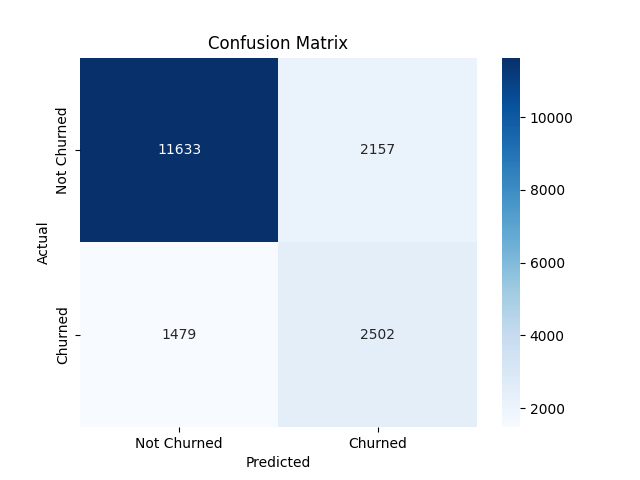

In [38]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_train_best_gbt_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

In [39]:
predictionAndLabels = pred_test_best_gbt_w.rdd.map(lambda lp: (float(lp.prediction), float(lp.label))).toDF().withColumnRenamed('_1', 'prediction').withColumnRenamed('_2', 'label')
metricsList_test_best_gbt_w = udfModelEvaluator(predictionAndLabels, "label")
metricsList_test_best_gbt_w

print('Metrics Test set:')
print(' ')
print(f'Accuracy: {metricsList_test_best_gbt_w[0]}')
print(f'Precision: {metricsList_test_best_gbt_w[1]}')
print(f'Recall: {metricsList_test_best_gbt_w[2]}')
print(f'F1-score: {metricsList_test_best_gbt_w[3]}')
print(' ')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Metrics Test set:
 
Accuracy: 0.800266311584554
Precision: 0.5533216783216783
Recall: 0.6193737769080235
F1-score: 0.5844875346260388

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

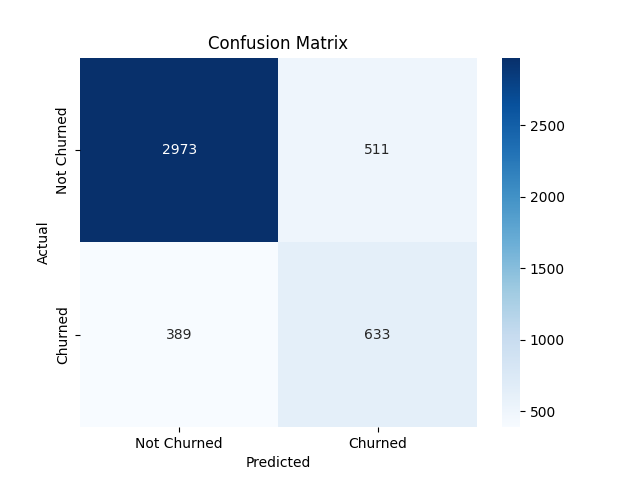

In [40]:
plt.clf()

ax= plt.subplot()
sns.heatmap(metricsList_test_best_gbt_w[4], annot=True, fmt='g', cmap='Blues', ax=ax)
ax.xaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.yaxis.set_ticklabels(['Not Churned', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

%matplot plt

<a class="anchor" id='chapter6'></a>
## Conclusions

We built an **ML pipeline to predict user churn** that consists of: <br>

- String indexer and encoder for categorical features.
- Feature assembler.
- Scaler: we use MinMaxScaler() which transforms each column value into the range [0,1], preserving the shape of the data.
- Classifier: Logistic Regression, Random Forest, Gradient-Boosting Tree.

For all classification models, we used **hyperparameter tuning and cross-validation**.

The **best performing model** according to the **F1 score** is the **gradient-boosted tree classifier** where **label weights** were included in the model **to account for the highly imbalanced dataset**. In fact, **the number of active users is more than three times the number of unsubscribed users**.<br> 

We use this **machine learning model trained on the full dataset on AWS EMR** to make predictions about customers on the **web application**. 